In [1]:
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "2"  # noqa

import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from typhon.files import FileSet, MHS_HDF, NetCDF4
from typhon.geographical import sea_mask
from typhon.plots import heatmap, styles, worldmap
from typhon.retrieval import SPAREICE
from typhon.utils import Timer, to_array
import xarray as xr

plt.style.use(styles('typhon'))

In [46]:
cpr = xr.open_dataset("data/2C-ICE_gridded_2008.nc")
cpr.load()
cgridded = cpr["2C-ICE_mean"].values

In [28]:
aspareice = xr.open_dataset("data/atmlab_SPARE-ICE_2008.nc")
aspareice.load()
aweights = aspareice.IWP_number / aspareice.IWP_number.sum("time")
agridded = (aweights * aspareice.IWP_mean).sum("time").values

In [50]:
tspareice = xr.open_dataset("data/typhon_SPARE-ICE_2008.nc")
tspareice.load()
tgridded = (tspareice.IWP_number * tspareice.IWP_mean / tspareice.IWP_number.sum("time")).sum("time").values

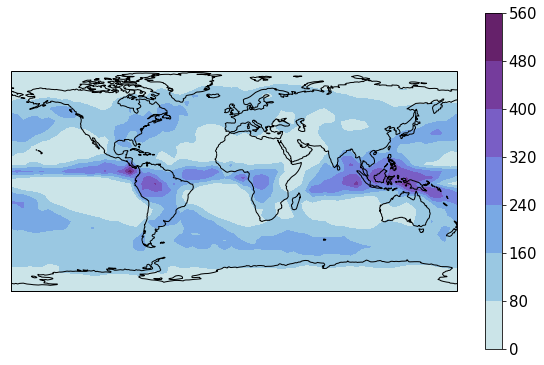

In [32]:
wmap = worldmap(aspareice.lat, aspareice.lon, agridded, cmap="density", draw_coastlines=True, vmax=640)
plt.colorbar(wmap)

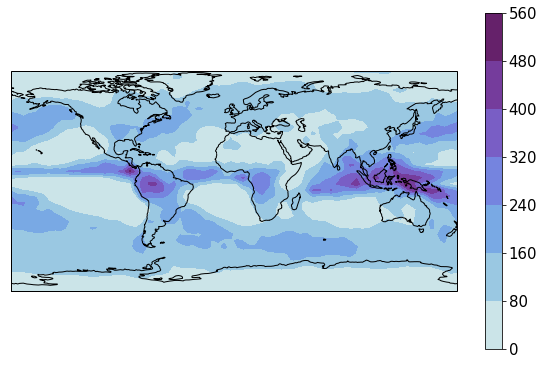

In [51]:
wmap = worldmap(tspareice.lat, tspareice.lon, tgridded, cmap="density", draw_coastlines=True, vmax=640)
plt.colorbar(wmap)

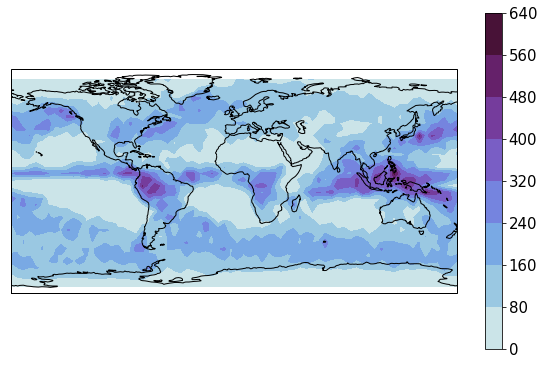

In [34]:
fig = plt.figure()
wmap = worldmap(cpr.lat, cpr.lon, cpr["2C-ICE_mean"], cmap="density", draw_coastlines=True, vmax=640)
plt.colorbar(wmap)

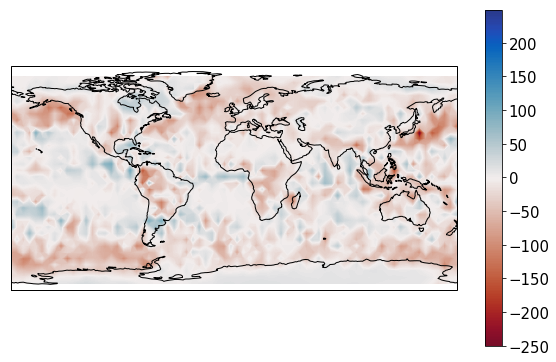

In [35]:
wmap = worldmap(cpr.lat, cpr.lon, agridded-cpr["2C-ICE_mean"], 
                cmap="difference_r", draw_coastlines=True, vmin=-300, vmax=300, levels=list(range(-250, 250)))
plt.colorbar(wmap)

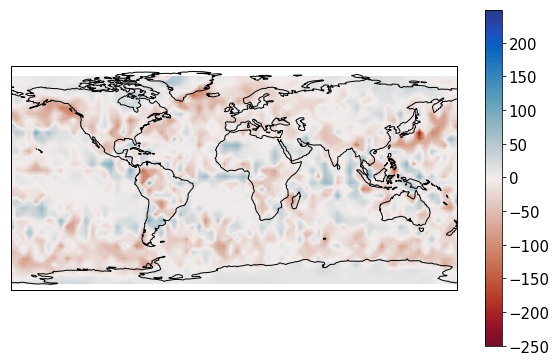

In [52]:
wmap = worldmap(cpr.lat, cpr.lon, tgridded-cpr["2C-ICE_mean"], 
                cmap="difference_r", draw_coastlines=True, vmin=-300, vmax=300, levels=list(range(-250, 250)))
plt.colorbar(wmap)

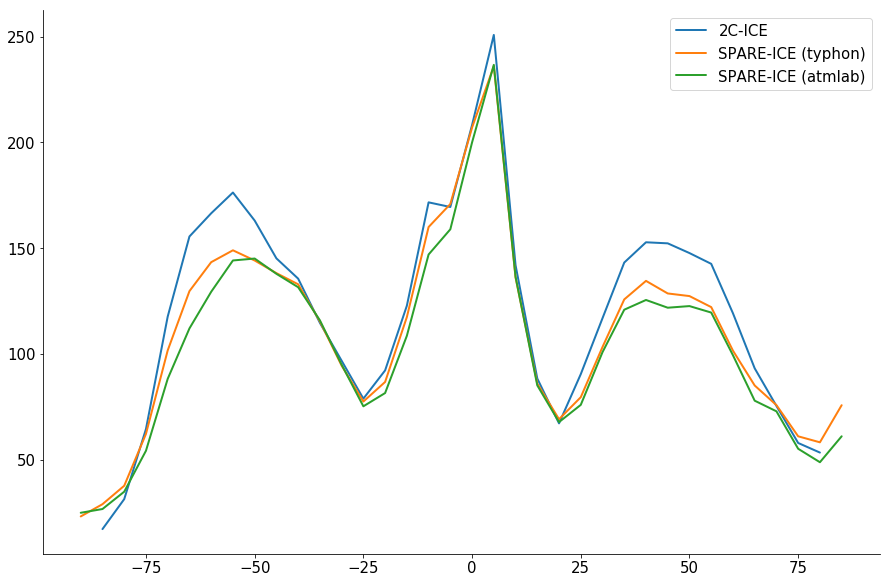

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(tspareice.lat.values, cgridded.mean(axis=1), label="2C-ICE")
ax.plot(tspareice.lat.values, tgridded.mean(axis=1), label="SPARE-ICE (typhon)")
ax.plot(tspareice.lat.values, agridded.mean(axis=1), label="SPARE-ICE (atmlab)")
ax.legend()

In [156]:
# compute appropriate bins to histogram the data into
lon_bins = np.arange(-180, 185, 5)
lat_bins = np.arange(-90, 95, 5)

# Histogram the lats and lons to produce an array of frequencies in each box.
# Because histogram2d does not follow the cartesian convention 
# (as documented in the numpy.histogram2d docs)
# we need to provide lats and lons rather than lons and lats
grid_sum, _, _ = np.histogram2d(
    ds.lat.values, ds.lon.values, [lat_bins, lon_bins], weights=ds.iwp.values
)

grid_number, _, _ = np.histogram2d(
    ds.lat.values, ds.lon.values, [lat_bins, lon_bins]
)
grid_mean = grid_sum / grid_number

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [159]:
grid_mean.shape

(36, 72)

In [160]:
lon_bins.size

73

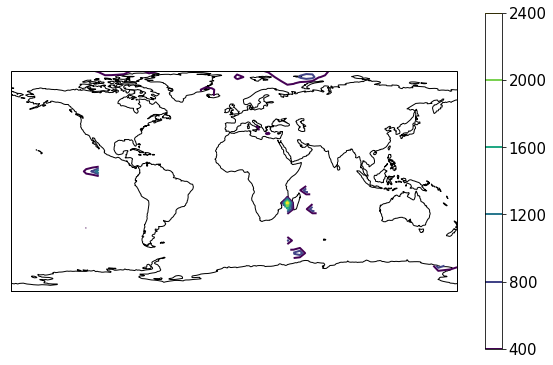

In [169]:
ax = plt.axes(projection=ccrs.PlateCarree())

c = plt.contour(lon_bins[:-1], lat_bins[:-1], grid_mean,
             transform=ccrs.PlateCarree())

ax.coastlines()
plt.colorbar(c)


In [148]:
density

array([[ 24.,  27.,  22., ...,  29.,  28.,  27.],
       [120., 110., 108., ..., 125., 122., 118.],
       [212., 216., 216., ..., 190., 196., 205.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   1.,   2., ...,   1.,   1.,   2.]])

In [139]:
def binned_statistic(coords, data, bins, statistic=None):
    """Bin data and calculate statistics on them
    
    As :func:`scipy.stats.binned_statistic` but faster for simple 
    statistics.
    
    Arg
    """
    bin_indices = np.digitize(coords, bins)
    return np.bincount(bin_indices,  weights=data, minlength=bins.size) / np.bincount(bin_indices, minlength=bins.size)

In [140]:
binned_mean(ds.lat.values, ds.iwp.values, np.arange(-90, 95, 5))

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([         nan,  15.83985272,  25.29452913,  33.5957126 ,
        45.42795198,  55.18805379,  37.90118073, 122.4313574 ,
        61.31172031,  36.92391729,  16.82366913,  38.83206572,
        27.55144817,   6.92870677, 227.91607215, 219.08407659,
       103.47490077, 132.3249684 ,   8.23038914,   1.5090919 ,
       243.26291604,  14.14667754,   2.62117245,  20.67510278,
        55.7100198 ,  51.01573349,  47.34411072,  33.90081178,
        24.51844567,  35.01265911,  61.40252552,  39.59233121,
        30.4285356 ,  78.58408146,  89.18164315, 184.87111991,
       375.82619478])

In [144]:
zonal_2c_ice = np.array([         np.nan,          np.nan,  17.11509072,  31.29149041,
        64.43582879, 117.60567063, 155.50858015, 166.44526321,
       176.56861456, 163.17099259, 145.15240491, 135.67554856,
       114.66852225,  96.75169486,  79.07215384,  92.31565659,
       122.9050801 , 171.83980522, 169.52712544, 208.68443078,
       251.19956005, 142.16233566,  88.50505466,  67.14553952,
        90.58704638, 117.07601075, 143.42744656, 152.80204592,
       152.26869433, 147.59914239, 142.65198391, 119.16983616,
        93.08807073,  75.37522083,  57.84635015,  53.3081244 ,
                np.nan])

In [142]:
bins = np.arange(-90, 95, 5)

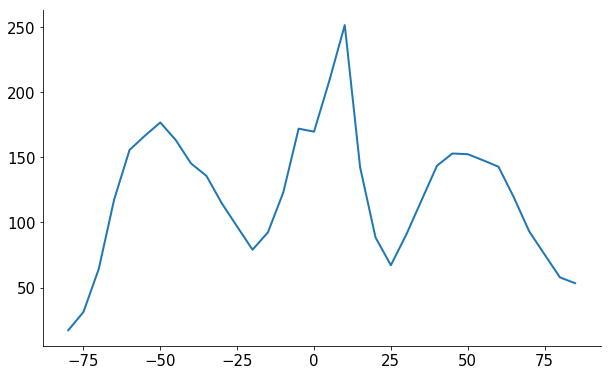

In [145]:
plt.plot(bins, zonal_2c_ice)

In [119]:
np.digitize(ds.lat.values, np.arange(-90, 90, 5))

array([23, 23, 23, ..., 25, 25, 25])

In [88]:
odata = NetCDF4().read("data/spareice_training_data.nc")
odata = odata.dropna(dim="collocation")

# Convert the collocated data to SPARE-ICE compatible data:
tdata = spareice.standardize_collocations(odata)
# Sometimes AVHRR channels 4 and 5 are 0, those are missing values
tdata = tdata[(tdata.avhrr_channel4 != 0) & (tdata.avhrr_channel5 != 0)]
tdata["sea_mask"] = sea_mask(
    tdata.lat, tdata.lon, "data/land_water_mask_5min.png"
)


def get_grid_value(grid, lat, lon):
    lat = to_array(lat)
    lon = to_array(lon)

    if lon.min() < -180 or lon.max() > 180:
        raise ValueError("Longitudes out of bounds!")

    if lat.min() < -90 or lat.max() > 90:
        raise ValueError("Latitudes out of bounds!")

    grid_lat_step = 180 / (grid.shape[0] - 1)
    grid_lon_step = 360 / (grid.shape[1] - 1)

    lat_cell = (90 - lat) / grid_lat_step
    lon_cell = lon / grid_lon_step

    return grid[lat_cell.astype(int), lon_cell.astype(int)]


ds = xr.open_dataset("data/surface_elevation_1deg.nc", decode_times=False)
elevation = ds.data.squeeze().values
tdata["elevation"] = get_grid_value(elevation, tdata.lat, tdata.lon)

# We do not need the depth of the oceans (this would just confuse the ANN)
tdata.elevation[tdata.elevation < 0] = 0

# We need ice water paths of 0 g/m^2 to train the ice cloud classifier.
# Unfortunately, zero values would not pass our inhomogeneity filter (
# because it would be NaN). Hence, we "mask" them as very small values:
not_null_tdata = tdata[(tdata.iwp_std / 10**tdata.iwp) < 0.5]
tdata = pd.concat([tdata[np.isnan(tdata.iwp)], not_null_tdata])


def balance(data, lat_bin, bin_points):
    bins = np.arange(-90, 90, lat_bin)
    balanced_data = []
    print(f"split into {bins.size} bins")
    rs = np.random.RandomState(1234)
    for bin_left in bins:
        mask = (bin_left <= data.lat) & (data.lat < bin_left + lat_bin)
        current_bin_points = mask.sum()
        if bin_points <= current_bin_points:
            wanted_bin_points = bin_points
        else:
            wanted_bin_points = current_bin_points

        bin_points_indices = mask.nonzero()[0]

        # We want to have more extreme viewing angles, so they are
        # not underrepresented.
        probability = (np.abs(
            data.mhs_scnpos.iloc[bin_points_indices] - 45) + 0.5) / 50
        probability /= probability.sum()

        print(f"Reduce {current_bin_points} to {wanted_bin_points}")
        selected_indices = rs.choice(
            bin_points_indices, wanted_bin_points, replace=False,
            p=probability
        )
        balanced_data.append(data.iloc[selected_indices])

    return pd.concat(balanced_data)


bin_width = 15
not_null = balance(tdata.dropna(), bin_width, 38_000)
null = balance(tdata[np.isnan(tdata.iwp)], bin_width, 38_000)
bdata = pd.concat([not_null, null])

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


split into 12 bins
Reduce 97400 to 38000
Reduce 154675 to 38000
Reduce 119251 to 38000
Reduce 71548 to 38000
Reduce 44546 to 38000
Reduce 81022 to 38000
Reduce 41548 to 38000
Reduce 21557 to 21557
Reduce 30813 to 30813
Reduce 36295 to 36295
Reduce 46285 to 38000
Reduce 29264 to 29264
split into 12 bins
Reduce 119721 to 38000
Reduce 103737 to 38000
Reduce 94126 to 38000
Reduce 172367 to 38000
Reduce 209104 to 38000
Reduce 148020 to 38000
Reduce 76159 to 38000
Reduce 111378 to 38000
Reduce 72934 to 38000
Reduce 41601 to 38000
Reduce 40408 to 38000
Reduce 32098 to 32098


In [90]:
not_null.lat.size*0.3

126578.7

split into 12 bins
Reduce 105105 to 33000
Reduce 168460 to 33000
Reduce 132430 to 33000
Reduce 80091 to 33000
Reduce 51635 to 33000
Reduce 93702 to 33000
Reduce 49956 to 33000
Reduce 25930 to 25930
Reduce 35938 to 33000
Reduce 41058 to 33000
Reduce 51216 to 33000
Reduce 32066 to 32066
split into 12 bins
Reduce 119721 to 38000
Reduce 103737 to 38000
Reduce 94126 to 38000
Reduce 172367 to 38000
Reduce 209104 to 38000
Reduce 148020 to 38000
Reduce 76159 to 38000
Reduce 111378 to 38000
Reduce 72934 to 38000
Reduce 41601 to 38000
Reduce 40408 to 38000
Reduce 32098 to 32098


838094

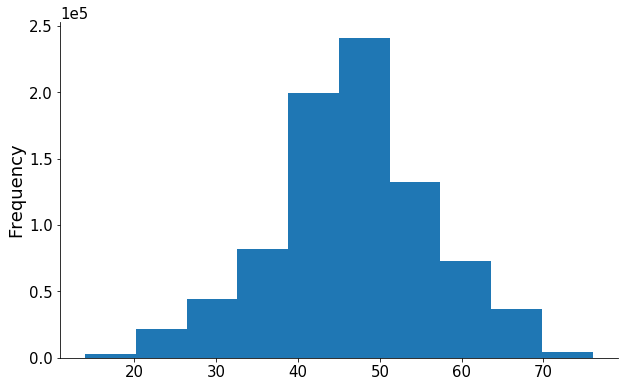

In [81]:
def balance(data, lat_bin, bin_points):
    bins = np.arange(-90, 90, lat_bin)
    balanced_data = []
    print(f"split into {bins.size} bins")
    rs = np.random.RandomState(1234)
    for bin_left in bins:
        mask = (bin_left <= data.lat) & (data.lat < bin_left + lat_bin)
        current_bin_points = mask.sum()
        if bin_points <= current_bin_points:
            wanted_bin_points = bin_points
        else:
            wanted_bin_points = current_bin_points
            
        bin_points_indices = mask.nonzero()[0]
        
        # We want to have more extreme viewing angles, so they are 
        # not underrepresented.
        probability = (np.abs(data.mhs_scnpos.iloc[bin_points_indices]-45)+0.5) / 50
        probability /= probability.sum()
        
        print(f"Reduce {current_bin_points} to {wanted_bin_points}")
        selected_indices = rs.choice(
            bin_points_indices, wanted_bin_points, replace=False,
            #p=probability
        )
        balanced_data.append(data.iloc[selected_indices])

    return pd.concat(balanced_data)


bin_width = 15
not_null = balance(tdata.dropna(), bin_width, 33_000)
null = balance(tdata[np.isnan(tdata.iwp)], bin_width, 38_000)
bdata = pd.concat([not_null, null])

# scat = heatmap(
#     bdata.mhs_scnpos,
#     bdata.lat, range=[[0, 90], [-90, 90]], bisectrix=False,
#     cmap="density", vmin=1,
# )
# scat.cmap.set_under("w")
# plt.colorbar(scat)

bdata.mhs_scnpos.plot.hist()
bdata.lat.size

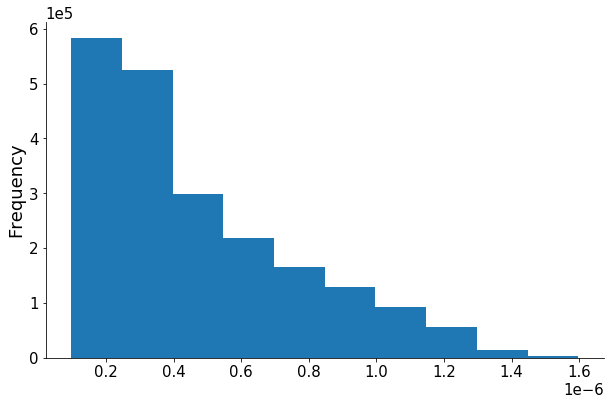

In [70]:
# We want to have more extreme viewing angles, so they are 
# not underrepresented.
probability = (np.abs(tdata.mhs_scnpos-45)+2) / 50
probability /= probability.sum()
probability.plot.hist()

In [6]:
mhs = FileSet(
    name="MHS",
    path="/scratch/uni/u237/data/amsub_mhs_l1c_hdf/AAPP7_13/noaa18"
         "_mhs_{year}/{month}/{day}/*NSS.MHSX.NN.*."
         "S{hour}{minute}.E{end_hour}{end_minute}.*.h5",
    handler=MHS_HDF(),
    # Load only the fields that we need:
    read_args={
        "fields": [
            "Data/btemps",
            "Geolocation/Satellite_azimuth_angle",
            "Geolocation/Satellite_zenith_angle",
            "Geolocation/Solar_azimuth_angle",
            "Geolocation/Solar_zenith_angle",
        ]
    },
)

In [19]:
experiments = FileSet("../{abc}/{name}/spareice.json")

In [20]:
for file in experiments:
    print(file.path)
    spareice = SPAREICE(file=file)
    print(spareice.iwp.inputs)

/scratch/uni/u237/users/jmrziglod/projects/spareice/experiments/spareice.json
['mhs_channel1', 'mhs_channel2', 'mhs_channel3', 'mhs_channel4', 'mhs_channel5', 'avhrr_tir_diff', 'lat', 'sea_mask', 'elevation', 'mhs_scnpos', 'solar_azimuth_angle', 'solar_zenith_angle', 'avhrr_channel3', 'avhrr_channel4', 'avhrr_channel5_std', 'avhrr_channel5']


In [23]:
experiments._user_placeholder

{'name': '(?P<name>.+?)', 'abc': '(?P<abc>.+?)'}

In [2]:
spareice = 

/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/dev/shm/u237002/anaconda36/envs/python36/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


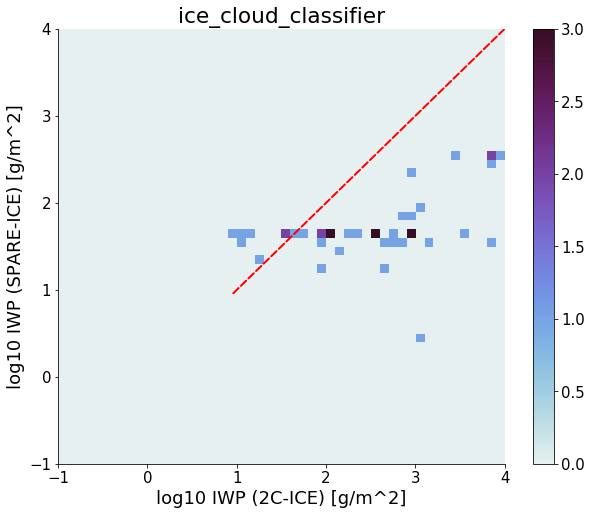

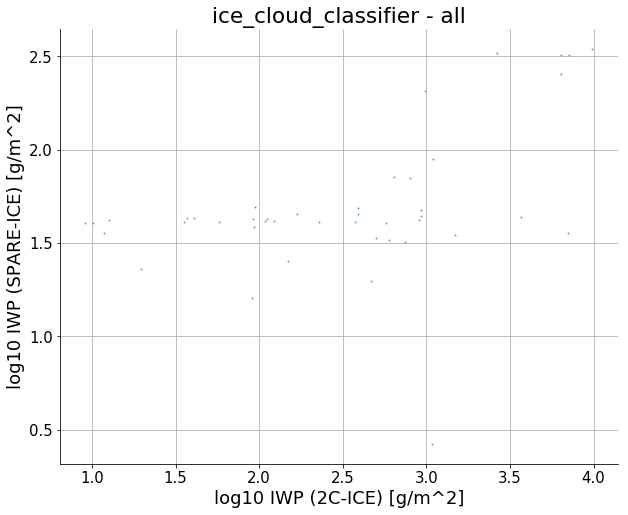

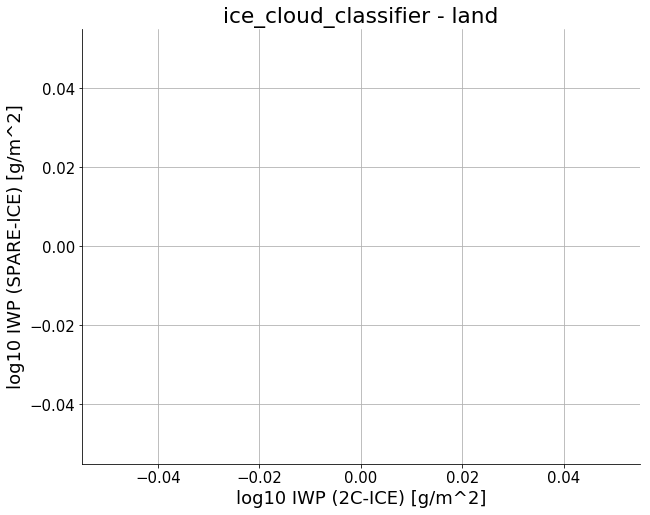

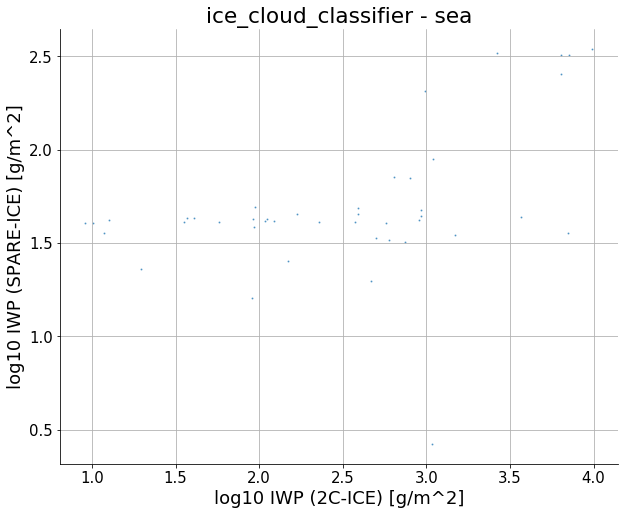

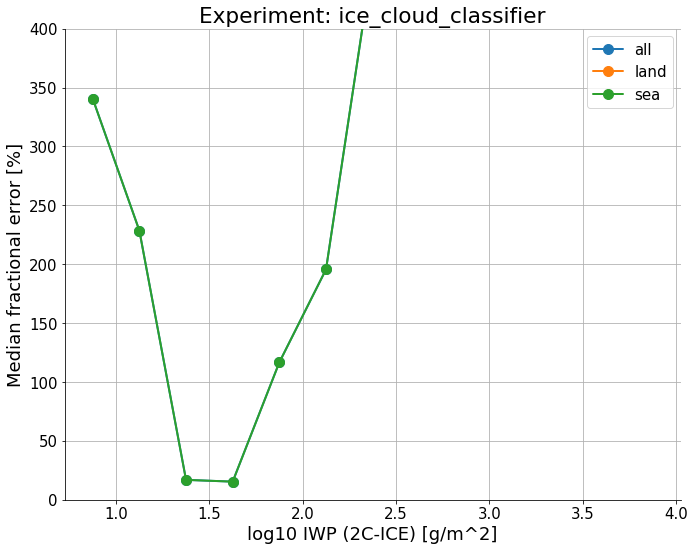

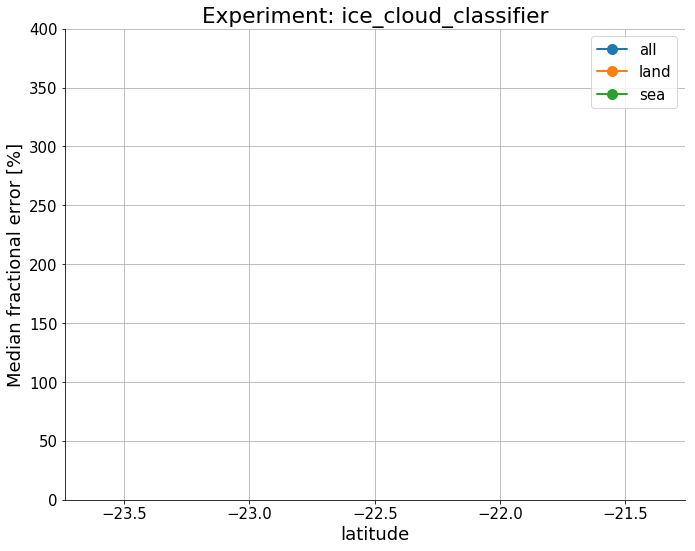

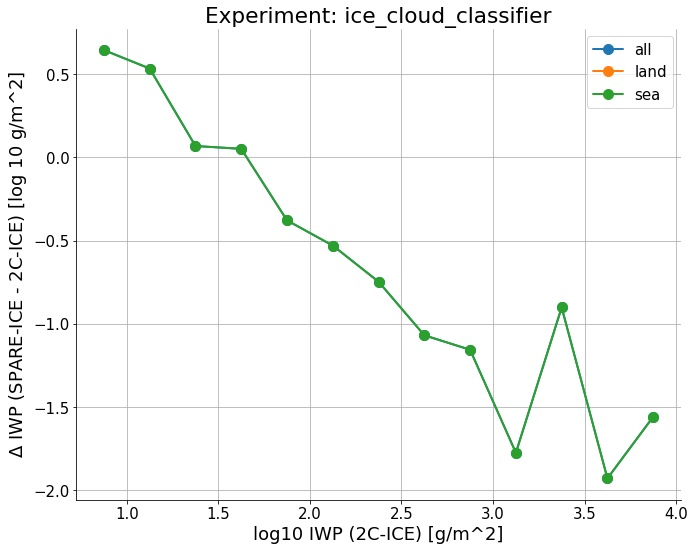

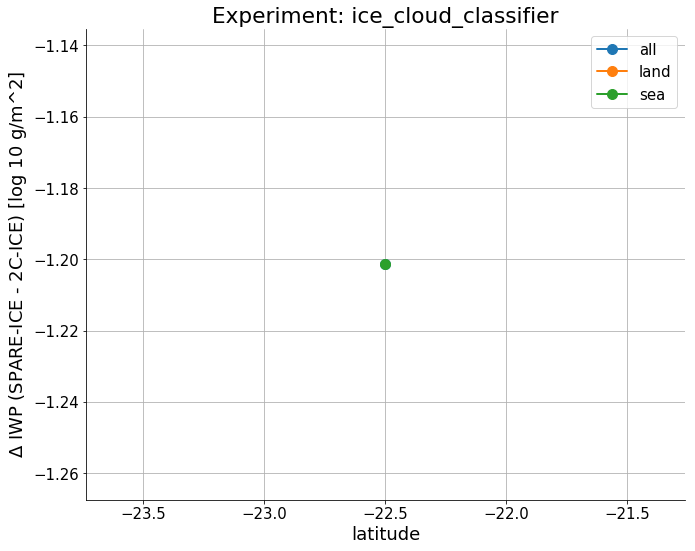

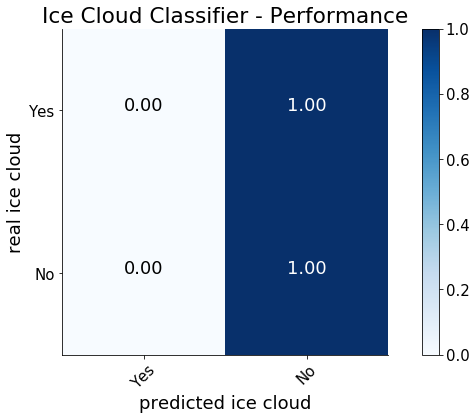

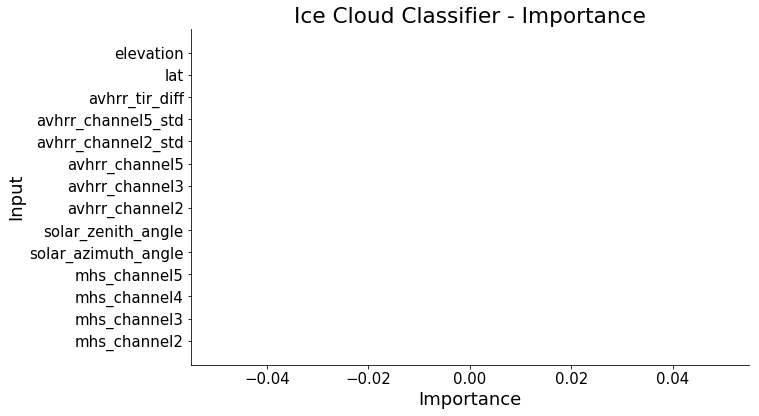

In [3]:
odata = NetCDF4().read("data/spareice_training_data.nc")
odata = odata.dropna(dim="collocation")
tdata = spareice.standardize_collocations(odata)

# Sometimes AVHRR channels 4 and 5 are 0, those are missing values
tdata = tdata[(tdata.avhrr_channel4 != 0) & (tdata.avhrr_channel5 != 0)]
tdata["sea_mask"] = sea_mask(
    tdata.lat, tdata.lon, "data/land_water_mask_5min.png"
)

def get_grid_value(grid, lat, lon):
    lat = to_array(lat)
    lon = to_array(lon)

    if lon.min() < -180 or lon.max() > 180:
        raise ValueError("Longitudes out of bounds!")

    if lat.min() < -90 or lat.max() > 90:
        raise ValueError("Latitudes out of bounds!")

    grid_lat_step = 180 / (grid.shape[0] - 1)
    grid_lon_step = 360 / (grid.shape[1] - 1)

    lat_cell = (90 - lat) / grid_lat_step
    lon_cell = lon / grid_lon_step

    return grid[lat_cell.astype(int), lon_cell.astype(int)]

ds = xr.open_dataset("data/surface_elevation_1deg.nc", decode_times=False)
elevation = ds.data.squeeze().values
tdata["elevation"] = get_grid_value(elevation, tdata.lat, tdata.lon)

# We do not need the depth of the oceans (this would just confuse the ANN)
tdata.elevation[tdata.elevation < 0] = 0

spareice.report("experiments", "ice_cloud_classifier", tdata.iloc[100:200])

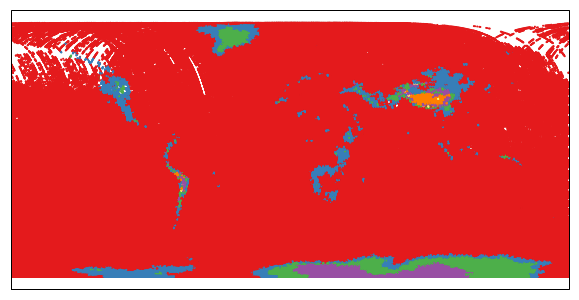

In [28]:
worldmap(tdata.lat, tdata.lon, tdata.elevation, rasterized=True)

In [ ]:
experiment = "test"
print(f"Perform experiment {experiment}")

# We need to train two retrievals: an ice cloud classifier and an IWP regressor
ice_cloud_fields = [
    'mhs_channel2',
    'mhs_channel3',
    'mhs_channel4',
    'mhs_channel5',
    'solar_azimuth_angle',
    'solar_zenith_angle',
    'avhrr_channel2',
    'avhrr_channel3',
    'avhrr_channel5',
    'avhrr_channel2_std',
    'avhrr_channel5_std',
    'avhrr_tir_diff',
    'lat', 'elevation'
]

iwp_fields = [
    "mhs_channel1", "mhs_channel2", "mhs_channel3", "mhs_channel4",
    "mhs_channel5", "avhrr_tir_diff", "lat", "sea_mask", "elevation",
    "mhs_scnpos", "solar_azimuth_angle",  "solar_zenith_angle", 
    "avhrr_channel3", "avhrr_channel4", "avhrr_channel5_std", 
    "avhrr_channel5"
]

os.makedirs(f"experiments/{experiment}", exist_ok=True)

# Create the SPARE-ICE object. It is not trained so far:
spareice = SPAREICE(verbose=2, processes=15)

odata = NetCDF4().read("data/spareice_training_data.nc")
odata = odata.dropna(dim="collocation")

spareice = SPAREICE(verbose=2)

# Convert the collocated data to SPARE-ICE compatible data:
tdata = spareice.convert_collocated_data(odata)
# Sometimes AVHRR channels 4 and 5 are 0, those are missing values
tdata = tdata[(tdata.avhrr_channel4 != 0) & (tdata.avhrr_channel5 != 0)]
tdata["sea_mask"] = sea_mask(
    tdata.lat, tdata.lon, "data/land_water_mask_5min.png"
)


def get_grid_value(grid, lat, lon):
    lat = to_array(lat)
    lon = to_array(lon)

    if lon.min() < -180 or lon.max() > 180:
        raise ValueError("Longitudes out of bounds!")

    if lat.min() < -90 or lat.max() > 90:
        raise ValueError("Latitudes out of bounds!")

    grid_lat_step = 180 / (grid.shape[0] - 1)
    grid_lon_step = 360 / (grid.shape[1] - 1)

    lat_cell = (90 - lat) / grid_lat_step
    lon_cell = lon / grid_lon_step

    return grid[lat_cell.astype(int), lon_cell.astype(int)]


ds = xr.open_dataset("data/surface_elevation_1deg.nc", decode_times=False)
elevation = ds.data.squeeze().values
tdata["elevation"] = get_grid_value(elevation, tdata.lat, tdata.lon)

# We do not need the depth of the oceans (this would just confuse the ANN)
tdata.elevation[tdata.elevation < 0] = 0

# We need ice water paths of 0 g/m^2 to train the ice cloud classifier.
# Unfortunately, zero values would not pass our inhomogeneity filter (
# because it would be NaN). Hence, we "mask" them as very small values:
not_null_tdata = tdata[(tdata.iwp_std / 10**tdata.iwp) < 0.45]
tdata = pd.concat([tdata[np.isnan(tdata.iwp)], not_null_tdata])


def balance(data, lat_bin, bin_points):
    bins = np.arange(-90, 90, lat_bin)
    balanced_data = []
    rest_data = []
    print(f"split into {bins.size} bins")
    for bin_left in bins:
        mask = (bin_left <= data.lat) & (data.lat < bin_left + lat_bin)
        current_bin_points = mask.sum()
        if bin_points <= current_bin_points:
            wanted_bin_points = bin_points
        else:
            wanted_bin_points = current_bin_points
        bin_points_indices = mask.nonzero()[0]
        print(f"Reduce {current_bin_points} to {wanted_bin_points}")
        selected_indices = np.random.choice(bin_points_indices,
                                            wanted_bin_points, replace=False)
        balanced_data.append(data.iloc[selected_indices])
        rest_indices = np.setdiff1d(np.arange(wanted_bin_points),
                                    selected_indices, assume_unique=True)
        rest_data.append(data.iloc[rest_indices])

    return pd.concat(balanced_data), pd.concat(rest_data)


bin_width = 15
not_null, _ = balance(tdata.dropna(), bin_width, 33_000)
null, _ = balance(tdata[np.isnan(tdata.iwp)], bin_width, 38_000)
bdata = pd.concat([not_null, null])

scat = heatmap(
    bdata.mhs_scnpos,
    bdata.lat, range=[[0, 90], [-90, 90]], bisectrix=False,
    cmap="density", vmin=1,
)
scat.cmap.set_under("w")
plt.colorbar(scat)
plt.savefig(f"experiments/{experiment}/scnpos_lat_heatmap.png")

train_data, test_data = train_test_split(
    bdata[:100], test_size=0.2, shuffle=True, random_state=5
)

print(f"Use {train_data.lat.size} points for training")
print(f"Use {train_data.lat.size} points for testing")

# Should we train SPARE-ICE?
if False:
    with Timer("SPARE-ICE training"):
        spareice.train(
            train_data,
            iwp_inputs=iwp_fields,
            ice_cloud_inputs=ice_cloud_fields
        )
    spareice.save(f"experiments/{experiment}/spareice.json")
    print(f"Testing score: {spareice.score(test_data)}")
else:
    spareice.load(f"experiments/{experiment}/spareice.json")

spareice.report("experiments/", experiment, test_data)
    
print(f"Experiment {experiment} was successfully performed!")

Perform experiment test


/scratch/uni/u237/users/jmrziglod/projects/typhon/typhon/retrieval/spareice/common.py:113: UserWarning: Could not load the standard parameters of SPARE-ICE!
You need to train SPARE-ICE by yourself.
  "Could not load the standard parameters of SPARE-ICE!\n"
/scratch/uni/u237/users/jmrziglod/projects/typhon/typhon/retrieval/spareice/common.py:116: UserWarning: malformed node or string: <_ast.Name object at 0x7fee0a795a90>
  warnings.warn(str(e))


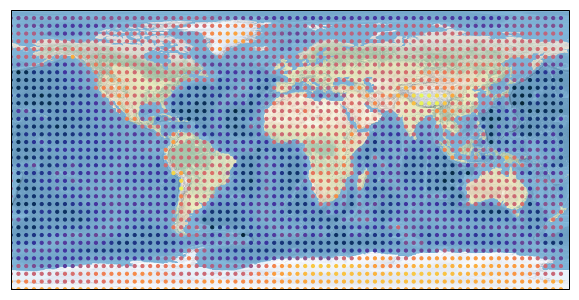

In [2]:
def get_grid_value(grid, lat, lon):

    lat = to_array(lat)
    lon = to_array(lon)

    if lon.min() < -180 or lon.max() > 180:
        raise ValueError("Longitudes out of bounds!")

    if lat.min() < -90 or lat.max() > 90:
        raise ValueError("Latitudes out of bounds!")

    grid_lat_step = 180 / (grid.shape[0] - 1)
    grid_lon_step = 360 / (grid.shape[1] - 1)

    lat_cell = (90 - lat) / grid_lat_step
    lon_cell = lon / grid_lon_step

    return grid[lat_cell.astype(int), lon_cell.astype(int)]

ds = xr.open_dataset("data/surface_elevation_1deg.nc", decode_times=False)
elevation = ds.data.squeeze().values

lat = np.arange(-90, 90, 5)
lon = np.arange(-180, 180, 5)
lat_grid, lon_grid = np.meshgrid(lat, lon)
lat = lat_grid.ravel()
lon = lon_grid.ravel()

#sea_mask(0., 0., "land_water_mask_5min.png")
worldmap(
    lat, lon, get_grid_value(elevation, lat, lon),
    bg=True, s=10, cmap="temperature"
)

In [3]:
spareice = SPAREICE(verbose=0)

odata = NetCDF4().read("data/spareice_training_data.nc")
odata = odata.dropna(dim="collocation")

# Convert the collocated data to SPARE-ICE compatible data:
tdata = spareice.convert_collocated_data(odata)
# Sometimes AVHRR channels 4 and 5 are 0, those are missing values
tdata = tdata[(tdata.avhrr_channel4 != 0) & (tdata.avhrr_channel5 != 0)]

# Add auxiliary data:
tdata["sea_mask"] = sea_mask(tdata.lat, tdata.lon, "data/land_water_mask_5min.png")
ds = xr.open_dataset("data/surface_elevation_1deg.nc", decode_times=False)
elevation = ds.data.squeeze().values
tdata["elevation"] = get_grid_value(elevation, tdata.lat, tdata.lon)
# tdata["local_time"] = tdata["time.hour"] + tdata.lon // 15
# tdata.local_time[tdata.local_time < 0] += 24
# tdata.local_time[tdata.local_time > 24] -= 24

# We need ice water paths of 0 g/m^2 to train the ice cloud classifier.
# Unfortunately, zero values would not pass our inhomogeneity filter (
# because it would be NaN). Hence, we "mask" them as very small values:
not_null_tdata = tdata[(tdata.iwp_std / 10**tdata.iwp) < 0.45]
tdata = pd.concat([tdata[np.isnan(tdata.iwp)], not_null_tdata])

/scratch/uni/u237/users/jmrziglod/projects/typhon/typhon/retrieval/spareice/common.py:107: UserWarning: Could not load the standard parameters of SPARE-ICE!
You need to train SPARE-ICE by yourself.
  "Could not load the standard parameters of SPARE-ICE!\n"
/scratch/uni/u237/users/jmrziglod/projects/typhon/typhon/retrieval/spareice/common.py:110: UserWarning: malformed node or string: <_ast.Name object at 0x7f1e9883e320>
  warnings.warn(str(e))


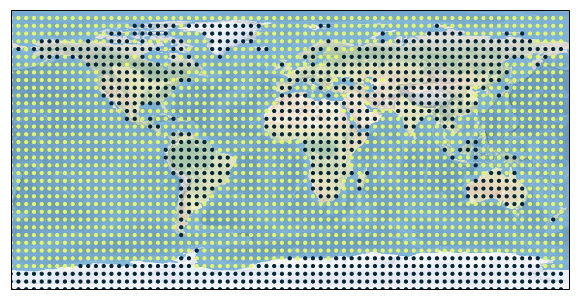

In [4]:
from typhon.geographical import sea_mask

lat = np.arange(-90, 90, 5)
lon = np.arange(-180, 180, 5)
lat_grid, lon_grid = np.meshgrid(lat, lon)
lat = lat_grid.ravel()
lon = lon_grid.ravel()

#sea_mask(0., 0., "land_water_mask_5min.png")
worldmap(
    lat, lon, sea_mask(lat, lon, "data/land_water_mask_5min.png").astype(int),
    bg=True, s=10, cmap="temperature"
)

In [5]:
def balance(data, lat_bin, bin_points):
    bins = np.arange(-90, 90, lat_bin)
    balanced_data = []
    rest_data = []
    print(f"split into {bins.size} bins")
    for bin_left in bins:
        mask = (bin_left <= data.lat) & (data.lat < bin_left + lat_bin)
        current_bin_points = mask.sum()
        wanted_bin_points = bin_points if bin_points <= current_bin_points else current_bin_points
        bin_points_indices = mask.nonzero()[0]
        print(f"Reduce {current_bin_points} to {wanted_bin_points}")
        selected_indices = np.random.choice(bin_points_indices, wanted_bin_points, replace=False)
        balanced_data.append(data.iloc[selected_indices])
        rest_indices = np.setdiff1d(np.arange(wanted_bin_points), selected_indices, assume_unique=True)
        rest_data.append(data.iloc[rest_indices])
        
    return pd.concat(balanced_data), pd.concat(rest_data)

bin_width = 15
not_null, _  = balance(tdata.dropna(), bin_width, 33_000)
null, _  = balance(tdata[np.isnan(tdata.iwp)], bin_width, 38_000)
bdata = pd.concat([not_null, null])

split into 12 bins
Reduce 92363 to 33000
Reduce 146121 to 33000
Reduce 111528 to 33000
Reduce 66407 to 33000
Reduce 40438 to 33000
Reduce 73574 to 33000
Reduce 36866 to 33000
Reduce 19131 to 19131
Reduce 28040 to 28040
Reduce 33529 to 33000
Reduce 43213 to 33000
Reduce 27402 to 27402
split into 12 bins
Reduce 119721 to 38000
Reduce 103737 to 38000
Reduce 94126 to 38000
Reduce 172367 to 38000
Reduce 209104 to 38000
Reduce 148020 to 38000
Reduce 76159 to 38000
Reduce 111378 to 38000
Reduce 72934 to 38000
Reduce 41601 to 38000
Reduce 40408 to 38000
Reduce 32098 to 32098


In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(bdata, test_size=0.2, shuffle=True, random_state=5)
ice_cloud_fields = [
    'mhs_channel2',
    'mhs_channel3',
    'mhs_channel4',
    'mhs_channel5',
    'solar_azimuth_angle',
    'solar_zenith_angle',
    'avhrr_channel2',
    'avhrr_channel3',
    'avhrr_channel5',
    'avhrr_channel2_std',
    'avhrr_channel5_std',
    'avhrr_tir_diff',
    'lat',
    'elevation',
]

iwp_fields = [
    "mhs_channel1", "mhs_channel2", "mhs_channel3", "mhs_channel4", "mhs_channel5", 
    "avhrr_tir_diff", "lat", "sea_mask", "mhs_scnpos", "solar_azimuth_angle", 
    "solar_zenith_angle", "avhrr_channel3", "avhrr_channel4", "avhrr_channel5_std", "avhrr_channel5", 'elevation',
]

spareice.train(
    train_data,
    iwp_inputs=iwp_fields,
    ice_cloud_inputs=ice_cloud_fields
)
spareice.save("test.json")

Best parameters found on training dataset:
 {'estimator__activation': 'tanh', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (15, 10, 3), 'estimator__random_state': 0, 'estimator__solver': 'lbfgs'}
-3.154 (+/-8.523) for {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (13, 10), 'estimator__random_state': 0, 'estimator__solver': 'lbfgs'}
-3.360 (+/-10.280) for {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (13, 10), 'estimator__random_state': 42, 'estimator__solver': 'lbfgs'}
-3.244 (+/-9.082) for {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (13, 10), 'estimator__random_state': 100, 'estimator__solver': 'lbfgs'}
-3.113 (+/-8.382) for {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (13, 10), 'estimator__random_state': 3452, 'estimator__solver': 'lbfgs'}
-2.802 (+/-6.741) for {'estimator__activation

In [9]:
spareice.load("test.json")

In [7]:
import itertools

def matrix(
        matrix, classes, normalize=False, ax=None, **kwargs
    ):
    """Plots the confusion matrix of 
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        
    default_kwargs = {
        "cmap": "Blues",
        **kwargs
    }
    
    if ax is None:
        ax = plt.gca()

    img = ax.imshow(matrix, interpolation='nearest', **default_kwargs)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        ax.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
        
    return img

Training: 0.9097615222656298
Testing: 0.8997170414093163


Text(0.5,1,'Ice Cloud Classifier - Importance')

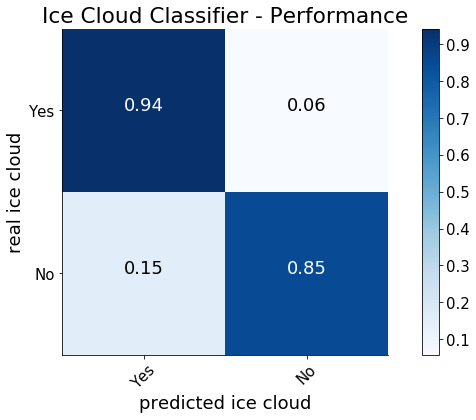

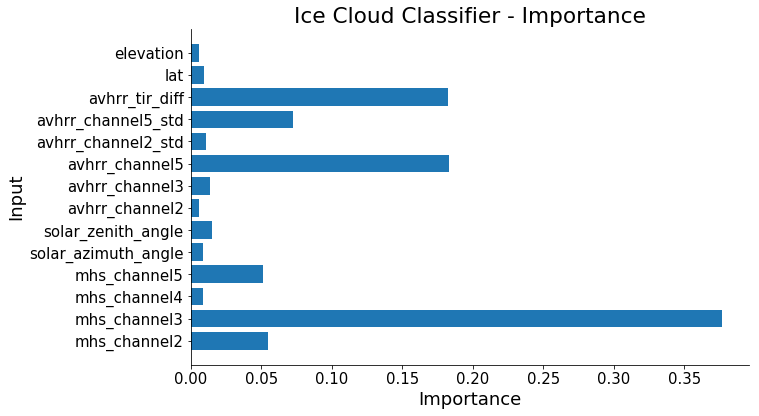

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

def train_and_test(model):
    model.fit(train_data[ice_cloud_fields], train_data["ice_cloud"])
    train_score = model.score(train_data[ice_cloud_fields], train_data["ice_cloud"])
    print(f"Training: {train_score}")
    test_score = model.score(test_data[ice_cloud_fields], test_data["ice_cloud"])
    print(f"Testing: {test_score}")

    retrieved = np.squeeze(model.predict(test_data[ice_cloud_fields]))
    targets = test_data[("ice_cloud")]

    fig, ax = plt.subplots()
    cm = confusion_matrix(targets, retrieved)
    img = matrix(cm, classes=["Yes", "No"], normalize=True)
    fig.colorbar(img)
    ax.set_title("Ice Cloud Classifier - Performance")
    ax.set_ylabel('real ice cloud')
    ax.set_xlabel('predicted ice cloud')
    fig.tight_layout()
    return retrieved, targets


model = DecisionTreeClassifier(max_depth=11, random_state=5)
retrieved, targets = train_and_test(model)

fig, ax = plt.subplots()
ax.barh(np.arange(len(ice_cloud_fields)), model.feature_importances_)
ax.set_yticks(np.arange(len(ice_cloud_fields)));
ax.set_yticklabels(ice_cloud_fields);
ax.set_xlabel("Importance")
ax.set_ylabel("Input")
ax.set_title("Ice Cloud Classifier - Importance")

In [26]:
test_score = model.score(test_data[ice_cloud_fields], test_data["ice_cloud"])
print(f"Testing: {test_score}")

retrieved = np.squeeze(model.predict(test_data[ice_cloud_fields]))
targets = test_data[("ice_cloud")]

Testing: 0.8997170414093163


Training: 0.9097615222656298
Testing: 0.8997170414093163


Text(0.5,1,'Ice Cloud Classifier - Importance')

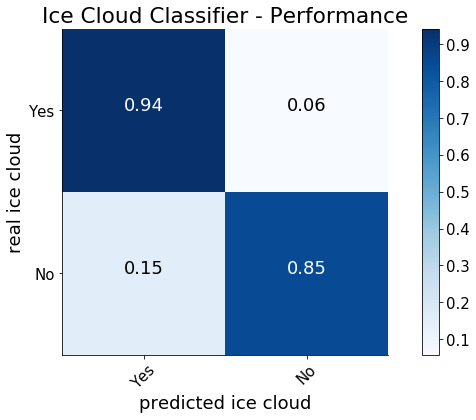

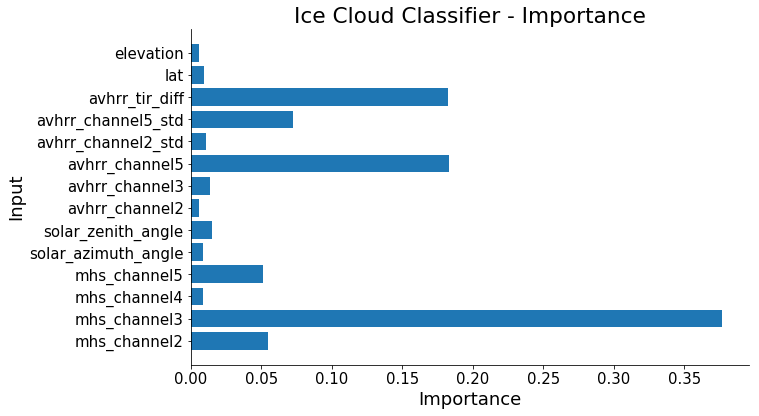

In [23]:
train_and_test(dtc)

fig, ax = plt.subplots()
ax.barh(np.arange(len(ice_cloud_fields)), dtc.feature_importances_)
ax.set_yticks(np.arange(len(ice_cloud_fields)));
ax.set_yticklabels(ice_cloud_fields);
ax.set_xlabel("Importance")
ax.set_ylabel("Input")
ax.set_title("Ice Cloud Classifier - Importance")

In [14]:
model.tree_.__getstate__()

{'max_depth': 11,
 'node_count': 3347,
 'nodes': array([(   1, 1620,  1, 245.13499451, 0.49545549, 657336, 6.57336e+05),
        (   2,  935, 11,  -0.5813393 , 0.41161937, 320717, 3.20717e+05),
        (   3,  432, 10,   0.41614902, 0.26774981, 226002, 2.26002e+05),
        ...,
        (3345, 3346,  2, 277.07501221, 0.49401855,    384, 3.84000e+02),
        (  -1,   -1, -2,  -2.        , 0.4787503 ,    325, 3.25000e+02),
        (  -1,   -1, -2,  -2.        , 0.41022695,     59, 5.90000e+01)],
       dtype=[('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]),
 'values': array([[[3.60002e+05, 2.97334e+05]],
 
        [[9.29390e+04, 2.27778e+05]],
 
        [[3.59860e+04, 1.90016e+05]],
 
        ...,
 
        [[2.13000e+02, 1.71000e+02]],
 
        [[1.96000e+02, 1.29000e+02]],
 
        [[1.70000e+01, 4.20000e+01]]])}

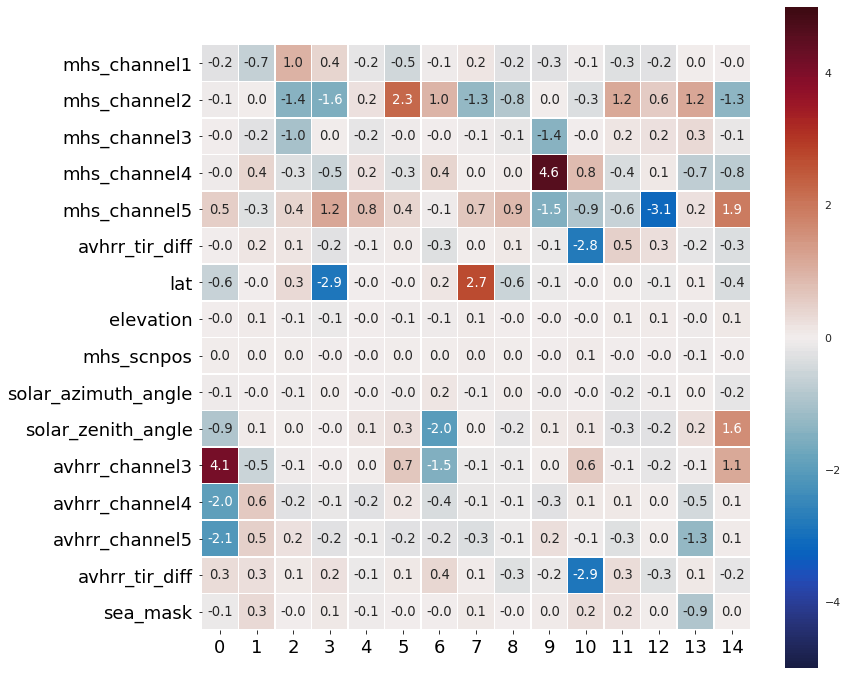

In [54]:
def show_weights(experiment, title, layer_index=0, vmin=-5, vmax=5):
    self = SPAREICE(file=f"experiments/{experiment}/spareice.json")
    import seaborn as sns
    sns.set_context("paper")

    layers = self.iwp.estimator.steps[-1][1].coefs_
    layer = layers[layer_index]
    f, ax = plt.subplots(figsize=(12, 10))
    weights = pd.DataFrame(layer)
    weights.index = self.iwp.inputs
    
    sns.set(font_scale=1.1)
    
    # Draw a heatmap with the numeric values in each cell
    sns.heatmap(
        weights, annot=True, fmt=".1f", linewidths=.5, ax=ax,
        square=True, cmap="difference", center=0, vmin=vmin, vmax=vmax,
        #annot_kws={"size":14},
    )
    ax.tick_params(labelsize=18)
    f.tight_layout()
    #f.savefig(file)

    sns.reset_orig()
show_weights("without_avhrr_std", "bla")

In [25]:
show_weights("without_avhrr_std")

AttributeError: __enter__